In [26]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import json
from sklearn.model_selection import train_test_split
import shutil

### Initial Visualization and Augmentation

In [2]:
def polygon_to_bounding_box(json_data, file):
    bounding_box_list = []
    for item in json_data[file].values():
        if isinstance(item, dict):
            if item != {}:
                length = len(item.values())
                for i in range(length):
                    print(item[str(i)]['shape_attributes']['all_points_x'])
                    print(item[str(i)]['shape_attributes']['all_points_y'])
                    poly_x = item[str(i)]['shape_attributes']['all_points_x']
                    poly_y = item[str(i)]['shape_attributes']['all_points_y']
                    # Compute bounding box
                    x_min, x_max = min(poly_x), max(poly_x)
                    y_min, y_max = min(poly_y), max(poly_y)
                    bbox_width = x_max - x_min
                    bbox_height = y_max - y_min
                    # Match format: [x, y, width, height]
                    bounding_box_list.append([int(x_min), int(y_min), int(bbox_width), int(bbox_height)])
    return bounding_box_list

In [3]:
def visualization(bboxes, labels, ax):
    for box, label in zip(bboxes, labels):
        # x_min, y_min, box_width, box_height = map(int, box)
        x_min, y_min, box_width, box_height = box
        if label == 'Thyrocyte' or label == 'Thyrocytes':
            rect = plt.Rectangle(
            ( x_min, y_min),
                box_width, box_height,
                linewidth=.2, edgecolor="blue", facecolor="none"
            )
        else:
            rect = plt.Rectangle(
            ( x_min, y_min),
                box_width, box_height,
                linewidth=.5, edgecolor="red", facecolor="none"
            )
        ax.add_patch(rect)
        ax.text(
            x_min, y_min - 5, label,
            color="blue", fontsize=2, weight="bold"
        )

In [4]:
def save(augmented_image, augmented_bboxes, augmented_labels, file):
    # aug_np = augmented_image.permute(1, 2, 0).cpu().numpy()
    Image.fromarray(augmented_image).save("augmented_" + file)

    # Save annotations
    aug_df = pd.DataFrame(augmented_bboxes, columns=["bbox_x", "bbox_y", "bbox_width", "bbox_height"])
    aug_df["label_name"] = augmented_labels
    csv_name = file.replace('.jpg', 'A.csv')
    aug_df.to_csv("augmented_" + csv_name, index=False)

In [5]:
transform = A.Compose(
    [
        # Geometric Transformations
        A.OneOf([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.RandomRotate90(p=1),
        ], p=1),
        # Photometric Transformations
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
        A.GaussNoise(std_range=(0.1, 0.2), p=1.0),
        A.CoarseDropout(
        num_holes_range=(3, 3),
        hole_height_range=(3, 3),
        hole_width_range=(3, 3),
        fill="random_uniform",
        p=0.5),
        # A.GridDropout(ratio=0.5, p=0.5)
        # ToTensorV2()
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

Processing image: LS-269.jpg
[1204.0168302945297, 1228.2704067321172, 1283.7071528751746, 1356.4678821879377, 1347.805890603085, 1346.0734922861143, 1271.5803646563809, 1228.2704067321172, 1157.2420757363248, 1100.0729312762967, 1081.0165497896207, 1051.5657784011214, 1032.5093969144455, 997.8614305750345, 964.9458625525942, 944.1570827489477, 904.3119214586251, 876.5935483870963, 859.2695652173909, 835.0159887798033, 810.7624123422156, 791.7060308555396, 809.030014025245, 845.4103786816265, 897.3823281907429, 880.0583450210374, 840.2131837307148, 833.2835904628326, 815.9596072931272, 814.2272089761567, 807.2976157082745, 809.030014025245, 805.5652173913039, 798.6356241234217, 779.5792426367458, 757.0580645161286, 750.1284712482465, 741.4664796633938, 731.0720897615705, 713.748106591865, 696.4241234221596, 680.8325385694246, 677.3677419354835, 673.9029453015424, 658.3113604488075, 647.9169705469842, 628.8605890603083, 609.8042075736322, 590.7478260869563, 571.6914446002802, 563.0294530

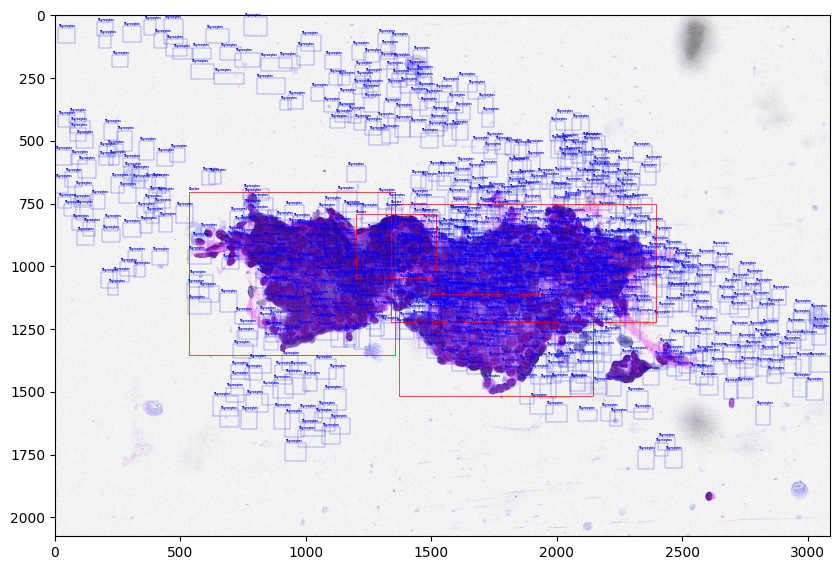

Processing image: LS-017.jpeg
[1298.4937913239792, 1281.06434446057, 1338.3325270117714, 1378.1712626995636, 1436.6844057410085, 1502.6673117239145, 1510.1370746653756, 1554.9556523141418, 1591.0595065312036, 1609.7339138848563, 1586.0796645702296, 1527.5665215287847, 1459.0936945653916, 1374.4363812288332, 1363.2317368166416, 1352.02709240445, 1300.9837123044663, 1298.4937913239792]
[944.0348330914363, 888.0116110304784, 879.2968875987739, 817.0488630865984, 782.1899693597802, 798.3744557329459, 830.743428479277, 873.0720851475563, 926.6053862280272, 983.8735687792285, 1046.121593291404, 1105.8796968230924, 1125.7990646669884, 1127.044025157232, 1057.3262377035956, 1026.2022254475078, 1003.7929366231247, 944.0348330914363]
[1028.3373649411378, 1044.5218513143034, 1079.3807450411216, 1103.0349943557483, 1132.9140461215925, 1178.9775842606023, 1215.081438477664, 1263.634897597161, 1264.8798580874045, 1252.4302531849694, 1200.141912594742, 1157.8132559264627, 1144.118690533784, 1120.4644

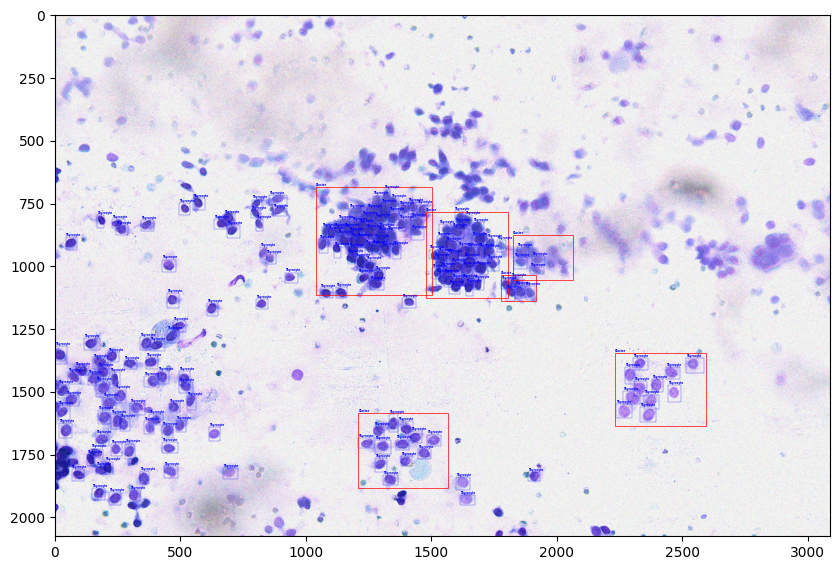

Processing image: LS-155.jpg
[1346.3209551014422, 1350.8445030396242, 1397.2108694059905, 1426.6139310041742, 1448.100783710539, 1444.7081227569024, 1487.6818281696321, 1525.0010986596344, 1557.7968212114545, 1621.1264923460037, 1624.5191532996403, 1591.7234307478202, 1557.7968212114545, 1621.1264923460037, 1677.6708415732796, 1681.0635025269162, 1618.8647183769126, 1600.7705266241842, 1575.891012964183, 1500.121584999633, 1449.2316706950846, 1414.1741741741735, 1393.818208452354, 1374.59312971508, 1332.750311286896, 1303.3472496887123, 1275.0750750750744, 1272.8133011059833, 1295.4310407968937, 1266.0279791987102, 1260.3735442759826, 1294.3001538123483, 1345.1900681168966, 1350.8445030396242, 1346.3209551014422]
[1438.5688127151534, 1438.5688127151534, 1473.6263092360646, 1461.1865524060638, 1405.7730901633333, 1368.453819673331, 1363.930271735149, 1317.5639053687828, 1316.4330183842371, 1311.9094704460551, 1257.62689518787, 1205.6060938987762, 1179.5956932542292, 1177.333919285138, 1

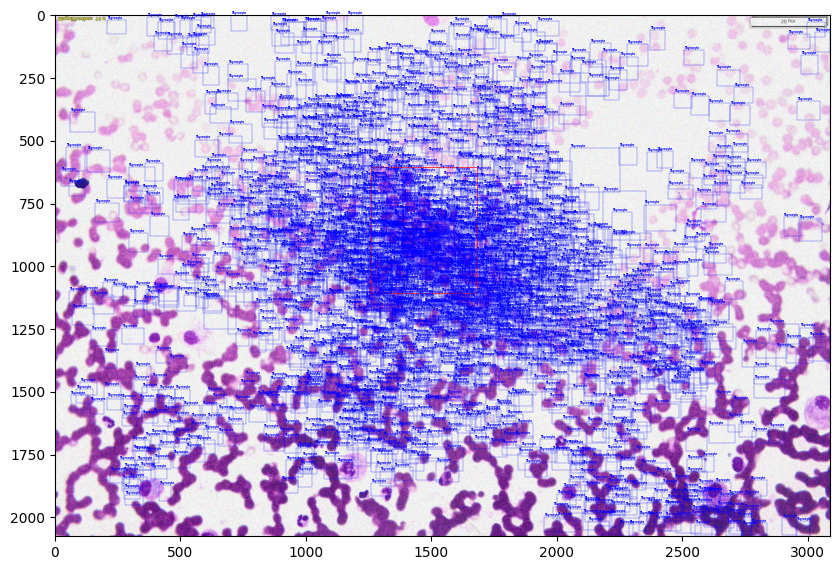

In [6]:
dataset = os.walk('/home/Special_Problem/Data')
for root, dirs, files in dataset:
    for file in files:
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            print(f"Processing image: {file}")
            format = file.split('.')[1]
            try:
                image = Image.open(os.path.join(root, file)).convert("RGB")
                
                path = os.path.join(root + " - ANNOTATED FILES", file.replace(f'.{format}', 'A.csv'))
                json_path = os.path.join(root + " - ANNOTATED FILES", file.replace(f'.{format}', 'B.json'))
                
                with open(json_path, 'r') as f:
                    json_data = json.load(f)
                df = pd.read_csv(path)
                
                df_labels  = df['label_name'].tolist()  # Assuming single class for simplicity
                df_bboxes = df[['bbox_x','bbox_y','bbox_width','bbox_height']].apply(lambda x: [x['bbox_x'], x['bbox_y'], x['bbox_width'], x['bbox_height']], axis=1).tolist()
                
                # From JSON polygons
                cluster_bboxes = polygon_to_bounding_box(json_data, file)
                cluster_labels = ["Cluster"] * len(cluster_bboxes)
                
                # Combine both
                all_bboxes = df_bboxes + cluster_bboxes
                all_labels = df_labels + cluster_labels
                
                fig, ax = plt.subplots(1, figsize=(10, 10))
                
                # Augment
                augmented = transform(image=np.array(image), bboxes=all_bboxes, labels=all_labels)
                augmented_image = augmented['image']
                augmented_bboxes = augmented['bboxes']
                augmented_labels = augmented['labels']
                
                ax.imshow(augmented_image.astype(np.uint8))
                visualization(augmented_bboxes, augmented_labels, ax)
                
                # ax.imshow(image)
                # visualization(all_bboxes, all_labels, ax)
                
                plt.show()
            except FileNotFoundError:
                print("File not found")
            break
        break

### CSV summary

In [7]:
dataset = os.walk('/home/Special_Problem/Data')
rows = []
# picture_format = set() # {'jpg', 'json', 'jpeg', 'png', 'csv'}
for root, dirs, files in dataset:
    for file in files:
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            print("Processing:", file)
            format = file.split('.')[1]
            try:
                image = Image.open(os.path.join(root, file)).convert("RGB")
                img_width, img_height = image.size
                
                path = os.path.join(root + " - ANNOTATED FILES", file.replace(f'.{format}', 'A.csv'))
                json_path = os.path.join(root + " - ANNOTATED FILES", file.replace(f'.{format}', 'B.json'))
                
                with open(json_path, 'r') as f:
                    json_data = json.load(f)
                df_csv = pd.read_csv(path)
                
                thyrocytes = df_csv['label_name'].count()
                
                clusters = 0
                for item in json_data[file].values():
                    if isinstance(item, dict) and item:
                        clusters += len(item.values())
                
                rows.append({
                    'File': file,
                    'Thyrocytes_Count': thyrocytes,
                    'Clusters_Count': clusters
                })
                
            except FileNotFoundError:
                print(f"{file} not found")

summary_df = pd.DataFrame(rows, columns=['File', 'Thyrocytes_Count', 'Clusters_Count'])
summary_df.to_csv('/home/Special_Problem/dataset_summary.csv', index=False)
print("Saved summary to /home/Special_Problem/dataset_summary.csv")


Processing: LS-269.jpg
Processing: LS-261.jpg
Processing: LS-190.jpg
Processing: LS-211.jpeg
Processing: LS-278.jpg
Processing: LS-208.jpeg
Processing: LS-192.jpg
Processing: LS-282.jpg
Processing: LS-248.jpg
Processing: LS-252.jpg
Processing: LS-209.jpeg
Processing: LS-215.jpg
Processing: LS-222.jpeg
Processing: LS-189.jpg
Processing: LS-270.jpg
Processing: LS-285.jpg
Processing: LS-232.jpg
Processing: LS-249.jpg
Processing: LS-234.jpg
Processing: LS-203.jpg
Processing: LS-241.jpg
Processing: LS-268.jpg
Processing: LS-237.jpg
Processing: LS-267.jpg
Processing: LS-226.jpeg
Processing: LS-258.jpg
Processing: LS-229.jpeg
Processing: LS-193.jpeg
Processing: LS-216.jpeg
Processing: LS-200.jpeg
Processing: LS-218.jpg
Processing: LS-266.jpg
Processing: LS-230.jpg
Processing: LS-239.jpg
Processing: LS-259.jpg
Processing: LS-196.jpg
Processing: LS-257.jpg
Processing: LS-207.jpeg
Processing: LS-256.jpg
Processing: LS-280.jpg
Processing: LS-214.jpg
Processing: LS-212.jpg
Processing: LS-243.jpg
P

In [8]:
def cluster_group(x):
    if x <= 4:
        return "low"
    elif x <= 10:
        return "medium"
    else:
        return "high"

In [9]:
summary = pd.read_csv('/home/Special_Problem/dataset_summary.csv')
summary["Cluster_Group"] = summary["Clusters_Count"].apply(cluster_group)

In [10]:
summary["Cluster_Group"].value_counts()

Cluster_Group
low       212
medium     36
high        8
Name: count, dtype: int64

In [11]:
# Stratified split (80% train, 10% val, 10% test)
train_df, temp_df = train_test_split(
    summary, test_size=0.2, stratify=summary["Cluster_Group"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["Cluster_Group"], random_state=42
)

In [12]:
train_df['Cluster_Group'].value_counts()

Cluster_Group
low       169
medium     29
high        6
Name: count, dtype: int64

In [13]:
val_df['Cluster_Group'].value_counts()

Cluster_Group
low       21
medium     4
high       1
Name: count, dtype: int64

In [14]:
test_df['Cluster_Group'].value_counts()

Cluster_Group
low       22
medium     3
high       1
Name: count, dtype: int64

In [15]:
train_df.to_csv('/home/Special_Problem/train_df_summary.csv', index=False)
val_df.to_csv('/home/Special_Problem/val_df_summary.csv', index=False)
test_df.to_csv('/home/Special_Problem/test_df_summary.csv', index=False)

### Conversion of Coco to Yolo

In [16]:
def get_normalize_bounding_box(x_min, y_min, bbox_width, bbox_height, img_width, img_height):
    x_center = (x_min + bbox_width / 2) / img_width
    y_center = (y_min + bbox_height / 2) / img_height
    w_norm = bbox_width / img_width
    h_norm = bbox_height / img_height
    return x_center, y_center, w_norm, h_norm

In [23]:
train_df = (pd.read_csv('/home/Special_Problem/train_df_summary.csv'))['File'].to_list()
val_df = (pd.read_csv('/home/Special_Problem/val_df_summary.csv'))['File'].to_list()
test_df = (pd.read_csv('/home/Special_Problem/test_df_summary.csv'))['File'].to_list()

In [25]:
def get_directory(file):
    if file in train_df:
        return "train"
    if file in val_df:
        return "val"
    if file in test_df:
        return "test"

In [27]:
def source_to_destination(src_path, destination_path):
    shutil.copy(src_path, destination_path)

In [30]:
dataset = os.walk('/home/Special_Problem/Data')
# {'Cluster', 'Clusters', 'Thyrocyte', 'Thyrocytes'}
label_map = {'Cluster' : 0, 'Clusters': 0, 'Thyrocyte': 1, 'Thyrocytes': 1}

# labels = set()
for root, dirs, files in dataset:
    for file in files:
        directory = get_directory(file)
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
            basename = file.split('.')[0]
            format = file.split('.')[1]
            try:
                source_path = os.path.join(root, file)
                destination_path = f"/home/Special_Problem/yolo_dataset/images/{directory}/{file}"
                source_to_destination(source_path, destination_path)
                
                image = Image.open(os.path.join(root, file)).convert("RGB")
                img_width, img_height = image.size
                
                path = os.path.join(root + " - ANNOTATED FILES", file.replace(f'.{format}', 'A.csv'))
                json_path = os.path.join(root + " - ANNOTATED FILES", file.replace(f'.{format}', 'B.json'))
                
                with open(json_path, 'r') as f:
                    json_data = json.load(f)
                df = pd.read_csv(path)
                
                out_path = f"/home/Special_Problem/yolo_dataset/labels/{directory}/{basename}.txt"
                with open(out_path, "w") as out_f:
                    
                    # Dataframe (Thyrocytes)
                    for _, row in df.iterrows():
                        class_id = label_map[row['label_name']]
                        x_min = row['bbox_x']
                        y_min = row['bbox_y']
                        bbox_width = row['bbox_width']
                        bbox_height = row['bbox_height']
                        
                        x_center, y_center, w_norm, h_norm = get_normalize_bounding_box(
                            x_min, y_min, bbox_width, bbox_height, img_width, img_height
                        )
                        out_f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
                        
                    # JSON (Clusters)
                    for item in json_data[file].values():
                        if isinstance(item, dict) and item:
                            for region in item.values():
                                label = region['region_attributes']["label"]
                                class_id = label_map[label]  # map to int
                                
                                poly_x = region['shape_attributes']['all_points_x']
                                poly_y = region['shape_attributes']['all_points_y']
                                
                                x_min, x_max = min(poly_x), max(poly_x)
                                y_min, y_max = min(poly_y), max(poly_y)
                                bbox_width = x_max - x_min
                                bbox_height = y_max - y_min
                                
                                x_center, y_center, w_norm, h_norm = get_normalize_bounding_box(
                                    x_min, y_min, bbox_width, bbox_height, img_width, img_height
                                )
                                out_f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")
                                
            except FileNotFoundError:
                print("File not found")